In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Attention,Embedding,Dense,Input,Flatten,Concatenate,Dropout,Conv1D,GlobalMaxPool1D,BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD,Adam
from tqdm import tqdm
from tensorflow.keras.layers import LeakyReLU

# Pull Gravity database

In [2]:
import functions as fn
grav_domains = fn.load_gravity(dir='').domain.values
grav_df = pd.DataFrame({'domain':grav_domains,'blocked':np.ones(len(grav_domains))})

# Pull Pi Hole DNS Data

In [3]:
from sqlalchemy import create_engine

def parse_domain(x):
    y = x.split('.')
    y = y[:-1]
    z = [i for i in y if i not in ['www']]
    return '.'.join(z)

db_connect = create_engine('sqlite:///pihole-FTL.db')
connection = db_connect.raw_connection()
df = pd.read_sql("SELECT * FROM queries", con=connection)
df['blocked'] = df.status.apply(lambda x: 0 if x in [2,3] else 1)           # 2,3 are domains blocked by gravity and
                                                                            # blacklist
df = pd.concat([df,grav_df]).reset_index()

np.savetxt('domains.txt',df.domain.values,fmt="%s")
print(df.head())

   index       id     timestamp  type  status                          domain  \
0      0  13094.0  1.600736e+09   1.0     1.0  mobile.pipe.aria.microsoft.com   
1      1  13095.0  1.600736e+09   2.0     1.0  mobile.pipe.aria.microsoft.com   
2      2  13096.0  1.600736e+09   1.0     1.0           telemetry.dropbox.com   
3      3  13097.0  1.600736e+09   1.0     2.0                  login.live.com   
4      4  13098.0  1.600736e+09   1.0     2.0                  edge.skype.com   

          client  forward additional_info  blocked  
0  192.168.0.119     None            None      1.0  
1  192.168.0.119     None            None      1.0  
2  192.168.0.147     None            None      1.0  
3  192.168.0.119  8.8.4.4            None      0.0  
4  192.168.0.119  8.8.4.4            None      0.0  


# Load/Train Tokenization Model

In [4]:
import random
import youtokentome as yttm

train_data_path = "domains.txt"
model_path = "./yttm_model/yttm_ads.model"

# Training model
if False:
    yttm.BPE.train(data=train_data_path, vocab_size=300, model=model_path)

# Loading model
bpe = yttm.BPE(model=model_path)

# Two types of tokenization
print(bpe.encode(list(' '.join(df.domain.values[0].split('.'))), output_type=yttm.OutputType.ID))
print(bpe.encode(list(df.domain.values[0]), output_type=yttm.OutputType.SUBWORD))
print(' '.join(df.domain.values[0].split('.')))

[[92], [4, 6], [142], [176], [251], [136], [], [104], [176], [104], [136], [], [91], [4, 17], [176], [91], [], [92], [176], [128], [4, 17], [4, 6], [88], [4, 6], [226], [218], [], [128], [4, 6], [92]]
[['▁m'], ['▁', 'o'], ['▁b'], ['▁i'], ['▁l'], ['▁e'], ['▁', '.'], ['▁p'], ['▁i'], ['▁p'], ['▁e'], ['▁', '.'], ['▁a'], ['▁', 'r'], ['▁i'], ['▁a'], ['▁', '.'], ['▁m'], ['▁i'], ['▁c'], ['▁', 'r'], ['▁', 'o'], ['▁s'], ['▁', 'o'], ['▁f'], ['▁t'], ['▁', '.'], ['▁c'], ['▁', 'o'], ['▁m']]
mobile pipe aria microsoft com


# Siamese Model with triplet loss/metric learning

In [51]:
class siamese():
    """
    Siamese embedding model for distance metric learning.

    Attributes
    ----------
    lr : float
        Learning rate for stochastic gradient descent optimizer
        (default 1e-2)

    Methods
    -------
    build_model:
        Defines and initializes the siamese/metric model.
    """

    def __init__(self,lr=1e-2):
        self.lr = lr
    
    @staticmethod
    def base_model():
        """
        Base embedding model.
        """
        query_input = Input(shape=(30,))
        token_embedding = tf.keras.layers.Embedding(input_dim=301, output_dim=128)
        query_embeddings = token_embedding(query_input)
        qdense1 = Dense(32,activation=LeakyReLU())(Flatten()(query_embeddings))
        qdense2 = Dense(32,activation=LeakyReLU())(qdense1)
        qdense3 = Dense(32,activation=LeakyReLU())(qdense2)
        return Model(inputs=query_input,outputs=qdense3)
    
    @staticmethod
    def metric():
        """
        Separate model for learning a metric that embeddings are
        projected onto.
        """
        inputs = Input(shape=(64,))
        d1 = Dense(8,activation=LeakyReLU())(inputs)
        d2 = Dense(8,activation=LeakyReLU())(d1)
        d3 = Dense(2,activation='softmax')(d2)
        return Model(inputs=inputs,outputs=d3[:,1:])
    
    @staticmethod
    def triplet_loss(true,pred):
        """
        Triplet loss with semi-hard negative mining.
        """
        m = 0.5 # pos anchor margin
        mask = tf.cast((pred[:,1] < pred[:,0] + m),tf.float32)
        loss = tf.reduce_sum(tf.maximum(tf.multiply(pred[:,0]**2 + m - pred[:,1]**2,mask),
                                                            tf.keras.backend.epsilon()))
        return loss

    @staticmethod
    def custom_acc(true,pred):
        """
        Custom accuracy based on comparative distances between positive
        and negative anchors.
        """
        pred_compare = tf.where(pred[:,0] < pred[:,1],True,False)
        total = tf.keras.backend.sum(tf.cast(pred_compare,tf.float32))
        return total/tf.cast(tf.size(pred_compare),tf.float32)

    def build_model(self):
        """
        Method for building complete metric distance learning siamese
        embedding model. Returns a keras object for batch training and
        prediction.
        """
        input_pos = Input(shape=(30,))
        input_neg = Input(shape=(30,))
        input_anchor_pos = Input(shape=(30,))
    
        ad_model = siamese.base_model()
        metric_model = siamese.metric()
    
        pos = ad_model(input_pos)
        anchor_pos = ad_model(input_anchor_pos)
        neg = ad_model(input_neg)
    
        AP = metric_model(Concatenate(axis=-1)([pos,anchor_pos]))
        AN = metric_model(Concatenate(axis=-1)([neg,anchor_pos]))

        distances = tf.keras.layers.concatenate([AP,AN],axis=1)
    
        metric_m = Model(inputs=[input_pos,input_neg,input_anchor_pos],outputs=distances)
        metric_m.compile(optimizer=SGD(learning_rate=self.lr),loss=siamese.triplet_loss,
                         metrics=[siamese.custom_acc])
        return metric_m


In [6]:
class model_wrapper():
    def __init__(self,ml_model,tok_model):
        self.ml_model = ml_model
        self.tok_model = tok_model
    def predict(self,x,y,z):
        encoded_x = pad_sequences(self.tok_model.encode([x], output_type=yttm.OutputType.ID),30,padding='post').reshape(1,50)
        encoded_y = pad_sequences(self.tok_model.encode([y], output_type=yttm.OutputType.ID),30,padding='post').reshape(1,50)
        encoded_z = pad_sequences(self.tok_model.encode([z], output_type=yttm.OutputType.ID),30,padding='post').reshape(1,50)
        return self.ml_model.predict([encoded_x,encoded_y,encoded_z])

In [52]:
def make_query_pairs(dframe,tokenizer,cls=0,sample_count=1000):
    """
    Function for constructing the training dataset for a quadruplet loss
    siamese metric distance learning model. Labels returned represent that
    of the positive sample and anchor class.
    """
    def numstr(suffix='www.'):
        """
        Function for generating random domains for testing.
        """
        nums = np.random.choice(['a','b','c','d','e','f'])
        ns = suffix+''.join([str(i) for i in nums])
        return ns
    
    sample_count = int(sample_count/2)
    blacklist = dframe.loc[dframe.blocked==1].reset_index()
    whitelist = dframe.loc[dframe.blocked==0].reset_index()
    bl_len = len(blacklist)
    wl_len = len(whitelist)
    samples = sample_count
    labels = np.random.choice([-1],size=samples)
    label_out = []
    pairs = []
    anchors_pos = []
    anchors_neg = []
    
    idx_bl_1 = np.random.choice(range(len(blacklist)),size=sample_count)
    idx_bl_anchor_1 = np.random.choice(range(len(blacklist)),size=sample_count)
    idx_wl_1 = np.random.choice(range(len(whitelist)),size=sample_count)
    idx_wl_anchor_1 = np.random.choice(range(len(whitelist)),size=sample_count)
    pos_1 = blacklist.loc[idx_bl_1].domain.values
    anchors_pos_1 = blacklist.loc[idx_bl_anchor_1].domain.values
    neg_1 = whitelist.loc[idx_wl_1].domain.values
    anchors_neg_1 = whitelist.loc[idx_wl_anchor_1].domain.values
    labels_1 = np.ones(len(pos_1))
    
    idx_bl_0 = np.random.choice(range(len(blacklist)),size=sample_count)
    idx_bl_anchor_0 = np.random.choice(range(len(blacklist)),size=sample_count)
    idx_wl_0 = np.random.choice(range(len(whitelist)),size=sample_count)
    idx_wl_anchor_0 = np.random.choice(range(len(whitelist)),size=sample_count)
    pos_0 = blacklist.loc[idx_bl_0].domain.values
    anchors_pos_0 = blacklist.loc[idx_bl_anchor_0].domain.values
    neg_0 = whitelist.loc[idx_wl_0].domain.values
    anchors_neg_0 = whitelist.loc[idx_wl_anchor_0].domain.values
    labels_0 = np.zeros(len(pos_0))
    
    pos = np.append(pos_0,neg_1)
    neg = np.append(neg_0,pos_1)
    anchors_pos = np.append(anchors_pos_0,anchors_neg_1)
    anchors_neg = np.append(anchors_neg_0,anchors_pos_1)
    labels = np.append(labels_1,labels_0)
    
    """
    for i,l in tqdm(enumerate(labels)):
        if l == -1:
            randval = np.random.rand()
            if (randval > 0.5):
                idx1 = np.random.choice(range(bl_len))
                idx2 = np.random.choice(range(wl_len))
                pairs.append((blacklist.iloc[idx1].domain,whitelist.iloc[idx2].domain))
                label_out.append(1)
                anch_idx_pos = np.random.choice(range(bl_len))
                anchors_pos.append(blacklist.iloc[anch_idx_pos].domain)
                anch_idx_neg = np.random.choice(range(wl_len))
                anchors_neg.append(whitelist.iloc[anch_idx_neg].domain)
            else:
                idx1 = np.random.choice(range(wl_len))
                idx2 = np.random.choice(range(bl_len))
                pairs.append((whitelist.iloc[idx1].domain,blacklist.iloc[idx2].domain))
                label_out.append(0)
                anch_idx_pos = np.random.choice(range(wl_len))
                anchors_pos.append(whitelist.iloc[anch_idx_pos].domain)
                anch_idx_neg = np.random.choice(range(bl_len))
                anchors_neg.append(blacklist.iloc[anch_idx_neg].domain)
        else:
            if np.random.randn() > 0.5:
                idx1 = np.random.choice(range(wl_len))
                idx2 = np.random.choice(range(wl_len))
                pairs.append((whitelist.iloc[idx1].domain,whitelist.iloc[idx2].domain))
                label_out.append(1.)
            else:
                idx1 = np.random.choice(range(bl_len))
                idx2 = np.random.choice(range(bl_len))
                pairs.append((blacklist.iloc[idx1].domain,blacklist.iloc[idx2].domain))
                label_out.append(1.)
    pos = [i[0] for i in pairs]
    neg = [i[1] for i in pairs]
    """
    return pos,neg,anchors_pos,anchors_neg,labels

def clean_df(dframe,clean_list=[]):
    dframe = dframe.loc[~dframe.domain.isin(clean_list)].reset_index(drop=True)
    return dframe

def test_queries(num=1000):
    def numstr():
        nums = np.random.choice(['a','b','c','d','e','f'])
        ns = 'www.'+''.join([str(i) for i in nums])+'.com'
        return ns
    def not_pre(x):
        if x == 0:
            return np.random.choice([1,2])
        elif x == 1:
            return np.random.choice([0,2])
        else:
            return np.random.choice([0,1])
    prefixes = np.array(['aa_','bb_','cc_'])
    idx = np.random.choice([0,1,2],size=num)
    pos = list(map(lambda x: prefixes[x]+numstr(),idx))
    anchor = list(map(lambda x: prefixes[x]+numstr(),idx))
    neg = list(map(lambda x: prefixes[not_pre(x)]+numstr(),idx))
    return pos,neg,anchor,idx

In [58]:
df_cleansed = clean_df(df,clean_list=list(df.domain[df.domain.apply(lambda x: len(x.split('.')[0]))>35].values)+['mobile.pipe.aria.microsoft.com'])

text_pos,text_neg,anchors_pos,anchors_neg,labels = make_query_pairs(df_cleansed,bpe,sample_count=50000)

text_pos = pad_sequences(list(map(lambda x: bpe.encode(x),text_pos)),30,padding='post')
text_neg = pad_sequences(list(map(lambda x: bpe.encode(x),text_neg)),30,padding='post')
anchors_pos = pad_sequences(list(map(lambda x: bpe.encode(x),anchors_pos)),30,padding='post')
anchors_neg = pad_sequences(list(map(lambda x: bpe.encode(x),anchors_neg)),30,padding='post')

def get_domain(cls=0):
    ct = 64
    text_ads,text_no_ads,anchors_ads,anchors_no_ads,labels = make_query_pairs(df,bpe,cls=cls,sample_count=ct)
    text_ads = pad_sequences(list(map(lambda x: bpe.encode(x),text_ads)),30,padding='post')
    text_no_ads = pad_sequences(list(map(lambda x: bpe.encode(x),text_no_ads)),30,padding='post')
    anchors_ads = pad_sequences(list(map(lambda x: bpe.encode(x),anchors_ads)),30,padding='post')
    anchors_no_ads = pad_sequences(list(map(lambda x: bpe.encode(x),anchors_no_ads)),30,padding='post')
    return text_ads.reshape(ct,-1),text_no_ads.reshape(ct,-1),anchors_ads.reshape(ct,-1)

# Train/Test/Validation Split

In [59]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(range(len(text_pos)),test_size=0.20, random_state=5)
test_,val_ = train_test_split(range(len(test)),random_state=10)
test = np.array(test)

pos_train = text_pos[train]
neg_train = text_neg[train]
anchor_pos_train = anchors_pos[train]
anchor_neg_train = anchors_neg[train]

pos_test = text_pos[test[test_]]
neg_test = text_neg[test[test_]]
anchor_pos_test = anchors_pos[test[test_]]
anchor_neg_test = anchors_neg[test[test_]]

pos_val = text_pos[test[val_]]
neg_val = text_neg[test[val_]]
anchor_pos_val = anchors_pos[test[val_]]
anchor_neg_val = anchors_neg[test[val_]]

In [63]:
dd_model = siamese(lr=1e-2).build_model() # initialize the model
dd_model.summary()

Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_56 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_58 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_57 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
model_33 (Model)                (None, 32)           163552      input_56[0][0]                   
                                                                 input_58[0][0]            

Train on 40000 samples, validate on 7500 samples
Epoch 1/30
40000/40000 [==============================] - 58s 1ms/sample - loss: 2.9998 - custom_acc: 0.5034 - val_loss: 3.0001 - val_custom_acc: 0.4981
Epoch 2/30
40000/40000 [==============================] - 53s 1ms/sample - loss: 2.9989 - custom_acc: 0.5015 - val_loss: 2.9992 - val_custom_acc: 0.4983
Epoch 3/30
40000/40000 [==============================] - 50s 1ms/sample - loss: 2.9851 - custom_acc: 0.5074 - val_loss: 2.9979 - val_custom_acc: 0.5044
Epoch 4/30
40000/40000 [==============================] - 48s 1ms/sample - loss: 2.9121 - custom_acc: 0.5179 - val_loss: 2.6156 - val_custom_acc: 0.5085
Epoch 5/30
40000/40000 [==============================] - 52s 1ms/sample - loss: 2.0865 - custom_acc: 0.5057 - val_loss: 1.9788 - val_custom_acc: 0.4940
Epoch 6/30
40000/40000 [==============================] - 50s 1ms/sample - loss: 1.8669 - custom_acc: 0.5055 - val_loss: 1.8989 - val_custom_acc: 0.4965
Epoch 7/30
40000/40000 [=========

(array([6.700e+01, 3.500e+01, 1.600e+01, 1.800e+01, 1.800e+01, 1.500e+01,
        1.000e+01, 1.900e+01, 1.600e+01, 1.900e+01, 2.400e+01, 3.600e+01,
        2.800e+01, 4.100e+01, 6.200e+01, 6.000e+01, 8.700e+01, 9.500e+01,
        1.270e+02, 1.800e+02, 2.560e+02, 3.120e+02, 4.180e+02, 5.270e+02,
        6.810e+02, 1.197e+03, 1.847e+03, 3.072e+03, 6.377e+03, 2.434e+04]),
 array([6.0702903e-05, 3.3391725e-02, 6.6722751e-02, 1.0005377e-01,
        1.3338479e-01, 1.6671582e-01, 2.0004685e-01, 2.3337787e-01,
        2.6670888e-01, 3.0003992e-01, 3.3337095e-01, 3.6670196e-01,
        4.0003300e-01, 4.3336400e-01, 4.6669504e-01, 5.0002605e-01,
        5.3335708e-01, 5.6668812e-01, 6.0001916e-01, 6.3335013e-01,
        6.6668117e-01, 7.0001221e-01, 7.3334324e-01, 7.6667422e-01,
        8.0000526e-01, 8.3333629e-01, 8.6666733e-01, 8.9999837e-01,
        9.3332934e-01, 9.6666038e-01, 9.9999142e-01], dtype=float32),
 <BarContainer object of 30 artists>)

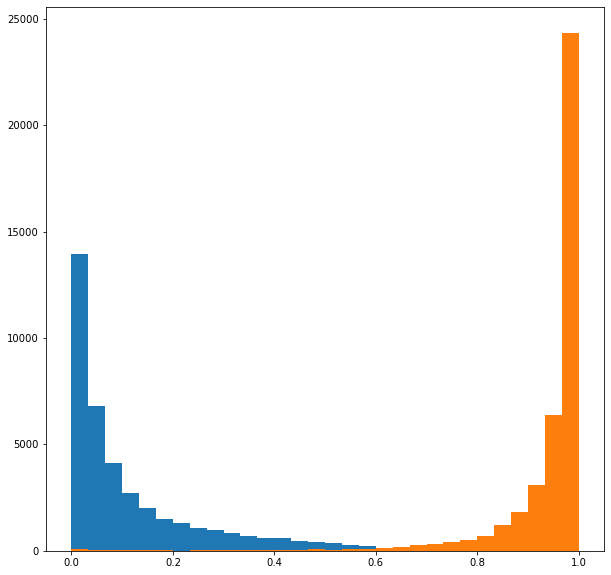

In [65]:
loss = []
val_loss = []

hist = dd_model.fit([pos_train,neg_train,anchor_pos_train,anchor_neg_train],np.zeros((len(pos_train),1)),epochs=30,batch_size=6,
                    validation_data=([pos_test,neg_test,anchor_pos_test,anchor_neg_test],np.zeros((len(pos_test),1))))
loss = hist.history['loss']
val_loss = hist.history['val_loss']

    
distances = dd_model.predict([pos_train,neg_train,anchor_pos_train,anchor_neg_train])
pl.figure(figsize=(10,10))
pl.hist(distances[:,0],bins=30)
pl.hist(distances[:,1],bins=30)

(0.0, 30.0)

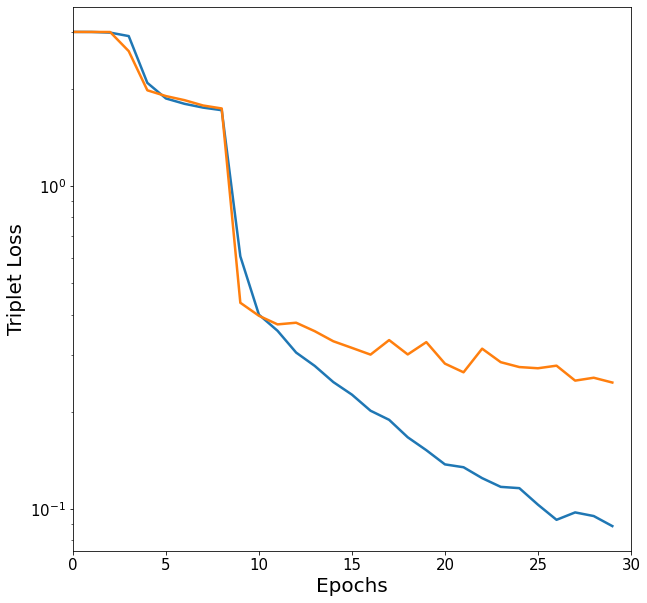

In [68]:
#distances = dd_model.predict([pos_test,neg_test,anchor_pos_test,anchor_neg_test])
#pl.figure(figsize=(10,10))
#pl.hist(distances[:,0],bins=30)
#pl.hist(distances[:,1],bins=30)

pl.figure(figsize=(10,10))
pl.plot((loss),lw=2.5)
pl.plot((val_loss),lw=2.5)
pl.ylabel('Triplet Loss',size=20)
#pl.ylabel(r'$log_{10}$Triplet Loss',size=20)
pl.xlabel('Epochs',size=20)
pl.yscale('log')
pl.yticks(size=15)
pl.xticks(size=15)
pl.xlim(0,30)

In [29]:
hist.history

{'loss': [0.4719631486468845],
 'custom_acc': [0.8915929],
 'val_loss': [2.8840259464581806],
 'val_custom_acc': [0.8041667]}

# Save the Model

In [156]:
tf.keras.models.save_model(dd_model,'./models/siamese_metric_quadruplet_loss_v1.h5')
# Example loading model back up with custom loss and accuracy
# model = tf.keras.models.load_model('./models/siamese_metric_triplet_loss.h5',custom_objects={'triplet_loss':triplet_loss,'custom_acc':custom_acc})

# Further Model Testing

In [69]:
# Load new test dataset
test_pos,test_neg,test_anchors_pos,test_anchors_neg,labels2 = make_query_pairs(df,bpe,sample_count=5000)

test_pos_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_pos)),30,padding='post')
test_neg_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_neg)),30,padding='post')
test_anchors_pos_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_anchors_pos)),30,padding='post')
test_anchors_neg_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_anchors_neg)),30,padding='post')

In [171]:
domain_stat_test = pad_sequences(np.sum(labels2==0)*[bpe.encode('wd5.myworkday.com')],30,padding='post')

In [70]:
domain_test_distances = dd_model.predict([test_pos_enc,test_neg_enc,test_anchors_pos_enc])
print(domain_test_distances[:,0])
print('Prob. domain is ad server: {0}%'.format((100.*domain_test_distances[:,0]).mean()))
#test_anchors_2
print(labels2[2])
#domain_test_distances[:,0]

[0.6348163  0.67800117 0.00986392 ... 0.02055496 0.00543522 0.0098192 ]
Prob. domain is ad server: 21.583168029785156%
1.0


In [199]:
def multi_pred(model,query,neg_example,neg_list,anchor_list):
    print(np.shape(anchor_list))
    predictions = model.predict([query,neg_example,neg_list,anchor_list])
    return (predictions[:,0]>=predictions[:,1]).mean()

multi_pred(dd_model,domain_stat_test,test_ref_enc,test_anchors_2_enc)

#domain_test_distances[:,0]
#(domain_test_distances[:,0]>=domain_test_distances[:,1]).mean()

NameError: name 'test_ref_enc' is not defined

In [150]:
labels2

array([0., 0., 0., ..., 1., 1., 1.])

# Look at Ad/No Ad Domains in Embedding

In [71]:
embed_model = Model(dd_model.layers[3].layers[1].input,dd_model.layers[3].layers[5].output)

In [72]:
pos = embed_model.predict(test_pos_enc)
neg = embed_model.predict(test_neg_enc)
pos_anchor = embed_model.predict(test_anchors_pos_enc)
neg_anchor = embed_model.predict(test_anchors_neg_enc)

In [73]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=3).fit(pos_anchor)
evr = np.round(100.*np.sum(pca_model.explained_variance_ratio_),0)
print('3 components explains {0} % of the variance.'.format(evr))
pca_neg = pca_model.transform(neg)
pca_pos = pca_model.transform(pos)
pca_anchor_pos = pca_model.transform(pos_anchor)

3 components explains 80.0 % of the variance.


In [96]:
np.sum(pca_model.explained_variance_ratio_)

0.936359

/Users/josh/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


<Figure size 720x720 with 0 Axes>

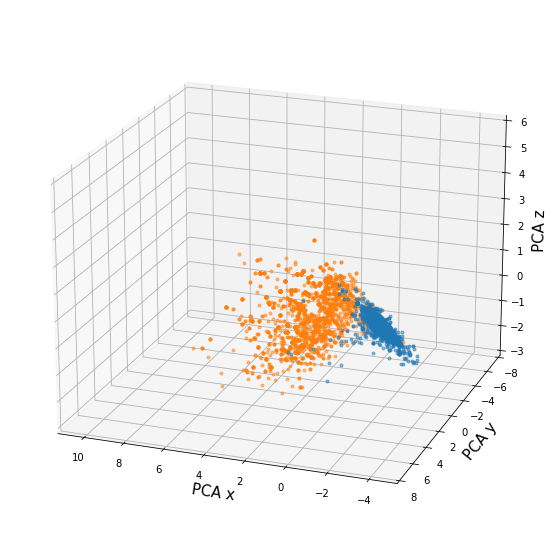

In [76]:
%matplotlib inline
from scipy.stats import kde
def kde_plot(x,y,colors=None):
    nbins=30
    k = kde.gaussian_kde([x,y])
    xi, yi = np.mgrid[min(x):max(x):nbins*1j, min(y):max(y):nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    pl.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=colors, alpha=0.5)

from mpl_toolkits import mplot3d
pl.ion()
pl.figure(figsize=(10,10))
fig = pl.figure(figsize=(10,10))
fig.show()
fig.canvas.draw()

ax = pl.axes(projection='3d')
ax.plot3D(pca_anchor_pos[:,0][labels2==0],pca_anchor_pos[:,1][labels2==0],pca_anchor_pos[:,2][labels2==0],
          '.',color='tab:orange',alpha=0.5)
ax.plot3D(pca_anchor_pos[:,0][labels2==1],pca_anchor_pos[:,1][labels2==1],pca_anchor_pos[:,2][labels2==1],
          '.',color='tab:blue',alpha=0.5)
#ax.plot3D(pca_anchor_pos[:,0][labels2==2],pca_anchor_pos[:,1][labels2==2],pca_anchor_pos[:,2][labels2==2],'.',color='red')
ax.set_xlim(-5,11)
ax.set_ylim(-8,8)
ax.set_zlim(-3,6)

ax.view_init(20,110)
ax.set_ylabel('PCA y',size=15)
ax.set_xlabel('PCA x',size=15)
ax.set_zlabel('PCA z',size=15)
pl.savefig('Embedding3DPlot.png')
#ax.plot(pca_anchor_pos[:,0][labels2==0],pca_anchor_pos[:,1][labels2==0], 'r+', zdir='y', zs=1.5)


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [0.6348163  0.67800117 0.00986392 0.02947959 0.7386748  0.8816067
 0.02666402 0.02274097 0.01179327 0.39074972] [0.6348163  0.67800117 0.00986392 0.02947959 0.7386748  0.8816067
 0.02666402 0.02274097 0.01179327 0.39074972]


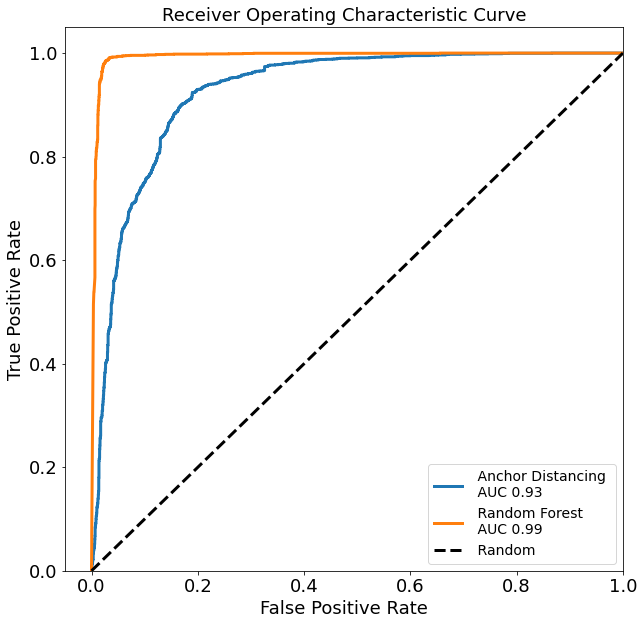

In [103]:
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=50,max_depth=4).fit(pos_anchor,labels2)
print(labels2[:10],domain_test_distances[:,0][:10],domain_test_distances[:,0][:10])

pl.figure(figsize=(10,10))
fpr,tpr,_ = roc_curve(labels2,np.abs(labels2 - domain_test_distances[:,0]))
fpr_RF,tpr_RF,_ = roc_curve(labels2,RF.predict_proba(pos)[:,1])

dist_auc = round(roc_auc_score(labels2,np.abs(labels2 - domain_test_distances[:,0])),2)
rf_auc = round(roc_auc_score(labels2,RF.predict_proba(pos)[:,1]),2)

pl.plot(fpr,tpr,color='tab:blue',lw=3,label=' Anchor Distancing \n AUC {0}'.format(dist_auc))
pl.plot(fpr_RF,tpr_RF,color='tab:orange',lw=3,label=' Random Forest \n AUC {0}'.format(rf_auc))
pl.plot(np.linspace(0,1,10),np.linspace(0,1,10),'k--',lw=3,label=' Random')
pl.xlabel('False Positive Rate',size=18)
pl.ylabel('True Positive Rate',size=18)
pl.xlim(-0.05,1.)
pl.ylim(0,1.05)
pl.xticks(size=18)
pl.yticks(size=18)
pl.legend(loc=0, prop={'size': 14})
pl.title('Receiver Operating Characteristic Curve',size=18)
pl.savefig('ROC_plot.png')
#pl.hist(domain_test_distances[:,0],bins=100)

In [131]:
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import f1_score
from copy import copy
class siamese_cv():
    def __init__(self,X,y):
        self.X = X
        self.y = y
        #self.model = model
        #self.model_ = copy(model)
        self.scores = []
        
    def cross_val(self):
        train,test = train_test_split(range(len(self.y)))
        predicts = np.ceil(np.floor(np.abs(self.X[test])-self.y[test]))
        self.scores.append(f1_score(self.y[test],predicts))
        
    def run_cross_val(self,n):
        [self.cross_val() for i in range(n)]
        return self.scores
        
#scorer = siamese_cv(pos_anchor,labels2)
#scorer.run_cross_val(5)
F = RandomForestClassifier(n_estimators=1,max_depth=6)
scores = cross_val_score(RF, pos,labels2, cv=5, scoring='f1_macro')

# Online Training Tests

In [336]:
# Reload model
def triplet_loss(true,pred):
    M = 1.
    loss = tf.reduce_mean(tf.maximum(pred[:,0]**2 - pred[:,1]**2 + M,0))
    return loss

def quadruplet_loss(true,pred):
    m1 = 1.
    m2 = .5
        #mask1 = tf.cast((pred[:,1] > pred[:,0]) & (pred[:,1] < pred[:,0] + m1),tf.float32)
        #mask2 = tf.cast((pred[:,3] > pred[:,2]) & (pred[:,3] < pred[:,2] + m2),tf.float32)
        
    mask1 = tf.ones_like(pred[:,1])#tf.cast((pred[:,1] > pred[:,0]) & (pred[:,1] < pred[:,0] + m1),tf.float32)
    mask2 = tf.ones_like(pred[:,1])#tf.cast((pred[:,2] > pred[:,1]) & (pred[:,2] < pred[:,1] + m2),tf.float32)
    loss = tf.reduce_sum(tf.maximum(tf.multiply(pred[:,0]**2 - pred[:,1]**2 + m1,mask1),0)) +\
               tf.reduce_sum(tf.maximum(tf.multiply(pred[:,2]**2 - pred[:,3]**2 + m2,mask2),0))
        #loss = tf.reduce_mean(pred[:,0]**2 + (pred[:,1]-m1)**2 + (pred[:,3]-m2)**2 + pred[:,2]**2)
    return loss
    
def custom_acc(true,pred):
    pred_ad = tf.cast(tf.where(pred[:,0] < pred[:,1] ,1,0),tf.int16)
    total = tf.keras.backend.sum(tf.cast(pred_ad,tf.float32))
    return total/tf.cast(tf.size(pred_ad),tf.float32)

#online_model = tf.keras.models.load_model('./models/siamese_metric_triplet_loss.h5',custom_objects={'triplet_loss':triplet_loss,'custom_acc':custom_acc})
online_model = tf.keras.models.clone_model(dd_model)#build_siamese() 
online_model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-3),loss=quadruplet_loss)
online_model.set_weights(dd_model.get_weights())
#online_model.optimizer.lr = 1e-3

In [327]:
dist_true = []
dist_false = []
dist_3rd = []

test_pos,test_neg,test_anchors_pos,test_anchors_neg,labels3 = make_query_pairs(df,bpe,sample_count=1000)
test_pos_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_pos)),30,padding='post')
test_neg_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_neg)),30,padding='post')
test_anchors_pos_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_anchors_pos)),30,padding='post')
test_anchors_neg_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_anchors_neg)),30,padding='post')

def adclass(label,metric_dists):
    class_dic = {0:1,1:0}
    
    if metric_dists[:,0] < metric_dists[:,3]: #< metric_dists[:,3]:
        return label
    else:
        return class_dic[label]

for i in range(1000):
    if i%2==0:
        request = np.random.choice(df.domain.values)
    else:
        request = np.random.choice(['googleadserver.com','www.homedepot.com'])
    domain_stat_test = pad_sequences(1*[bpe.encode(request)],30,padding='post')
    print(request,test_neg[i],test_anchors_pos[i])
    init_preds1 = online_model.predict([domain_stat_test,test_neg_enc[i].reshape(1,-1),test_anchors_pos_enc[i].reshape(1,-1),test_anchors_neg_enc[i].reshape(1,-1)])
    #init_preds2 = online_model.predict([test_pos_enc[i].reshape(1,-1),domain_stat_test,test_anchors_pos_enc[i].reshape(1,-1),test_anchors_neg_enc[i].reshape(1,-1)])
    
    print(init_preds1[:,0],init_preds1[:,3])
    if (init_preds1[:,1] < init_preds1[:,0]) & (init_preds1[:,0] < init_preds1[:,3]):
        online_model.fit([domain_stat_test,test_neg_enc[i].reshape(1,-1),test_anchors_pos_enc[i].reshape(1,-1),test_anchors_neg_enc[i].reshape(1,-1)],np.zeros(1),epochs=1)
    #elif (init_preds1[:,0] > init_preds1[:]:   
    #    online_model.fit([test_pos_enc[i].reshape(1,-1),domain_stat_test,test_anchors_pos_enc[i].reshape(1,-1),test_anchors_neg_enc[i].reshape(1,-1)],np.zeros(1),epochs=1)
    #print(init_preds)
    print('Domain is ad server(pre): ',(init_preds1[:,0]))#>=init_preds[:,1]).mean())
    post_preds = online_model.predict([domain_stat_test,test_neg_enc[i].reshape(1,-1),test_anchors_pos_enc[i].reshape(1,-1),test_anchors_neg_enc[i].reshape(1,-1)])
    #print(post_preds)
    print('Domain is ad server(post): ',(post_preds[:,0]))#>=post_preds[:,1]).mean())
    if request == 'googleadserver.com':
        dist_true.append(adclass(labels3[i],post_preds))
    elif request == 'www.homedepot.com':
        dist_false.append(adclass(labels3[i],post_preds))
    test_case = pad_sequences(1*[bpe.encode('c.aaxads.com')],30,padding='post') 
    test_pred = online_model.predict([test_case,test_neg_enc[i].reshape(1,-1),test_anchors_pos_enc[i].reshape(1,-1),test_anchors_neg_enc[i].reshape(1,-1)])
    dist_3rd.append(adclass(labels3[i],test_pred))

1000it [00:44, 22.35it/s]


zdjecie-ukradzione.eu weather-data.apple.com api.adcalls.nl
[5.303842e-06] [8.5788175e-05]
Domain is ad server(pre):  [5.303842e-06]
Domain is ad server(post):  [5.303842e-06]
googleadserver.com device-metrics-us.amazon.com 155.0.168.192.in-addr.arpa
[0.99999] [7.339782e-05]
Domain is ad server(pre):  [0.99999]
Domain is ad server(post):  [0.99999]
static-exp1.licdn.com www.linkedin.com pixel.adsniper.ru
[0.9999989] [1.8351659e-05]
Domain is ad server(pre):  [0.9999989]
Domain is ad server(post):  [0.9999989]
www.homedepot.com thestar.serveblog.net e673.dsce9.akamaiedge.net
[0.99996305] [0.00022623]
Domain is ad server(pre):  [0.99996305]
Domain is ad server(post):  [0.99996305]
ocsp.g.aaplimg.com a-0001.a-afdentry.net.trafficmanager.net watch-this.live
[0.9999999] [8.250875e-11]
Domain is ad server(pre):  [0.9999999]
Domain is ad server(post):  [0.9999999]
googleadserver.com play.google.com ph-ad21.focalink.com
[0.00016932] [0.99997914]
Domain is ad server(pre):  [0.00016932]
Domain i

[1.] [0.9997038]
Domain is ad server(pre):  [1.]
Domain is ad server(post):  [1.]
googleadserver.com gtq.sct.sc-prod.net dotster.112.2o7.net
[0.00075284] [0.99999356]
Domain is ad server(pre):  [0.00075284]
Domain is ad server(post):  [0.00075284]
ssl.google-analytics.com apidata.googleusercontent.com onlineprzelew.tech
[1.3535304e-05] [0.00082689]
Domain is ad server(pre):  [1.3535304e-05]
Domain is ad server(post):  [1.3535304e-05]
www.homedepot.com detectportal.firefox.com imt-aq.com
[0.99994886] [0.99996483]
Domain is ad server(pre):  [0.99994886]
Domain is ad server(post):  [0.99994886]
ss-prod-ue1-notif-59.aws.adobess.com rs1.qq.com k-ring.msedge.net
[0.00029192] [0.99705184]
Domain is ad server(pre):  [0.00029192]
Domain is ad server(post):  [0.00029192]
googleadserver.com cont.p-cdn.us bucephalus.in
[2.2274844e-05] [0.9999913]
Domain is ad server(pre):  [2.2274844e-05]
Domain is ad server(post):  [2.2274844e-05]
www-nytimes-com.cdn.ampproject.org ocsp.apple.com sbkozmohwzerlldb

[2.7932172e-05] [0.9999896]
Domain is ad server(pre):  [2.7932172e-05]
Domain is ad server(post):  [2.7932172e-05]
aws.api.snapchat.com nppl.app.nintendo.net ads.socialtheater.com
[1.] [2.4559164e-05]
Domain is ad server(pre):  [1.]
Domain is ad server(post):  [1.]
www.homedepot.com telemetry.malwarebytes.com www3.l.google.com
[0.9999968] [0.00021422]
Domain is ad server(pre):  [0.9999968]
Domain is ad server(post):  [0.9999968]
expertchief.website adserver.pressflex.com cc-api-data.adobe.io
[0.34189567] [6.274319e-06]
Domain is ad server(pre):  [0.34189567]
Domain is ad server(post):  [0.34189567]
googleadserver.com adserver.advertist.com alb.reddit.com
[0.99998534] [9.308413e-05]
Domain is ad server(pre):  [0.99998534]
Domain is ad server(post):  [0.99998534]
telemetry.malwarebytes.com preview.redd.it assueameli.beget.tech
[2.7759108e-06] [1.634306e-08]
Domain is ad server(pre):  [2.7759108e-06]
Domain is ad server(post):  [2.7759108e-06]
www.homedepot.com alb.reddit.com siteimprovea

1/1 [==============================] - 0s 83ms/sample - loss: 1.5014
Domain is ad server(pre):  [0.00029215]
Domain is ad server(post):  [0.00029213]
www.reddit.com dms.licdn.com cj02673.tmweb.ru
[1.] [1.4416012e-06]
Domain is ad server(pre):  [1.]
Domain is ad server(post):  [1.]
googleadserver.com gateway.fe.apple-dns.net eu-sonar.sociomantic.com
[0.01487045] [0.9999397]
Domain is ad server(pre):  [0.01487045]
Domain is ad server(post):  [0.01487045]
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b.cws.conviva.com api.us-east-1.aiv-delivery.net gmglobalt3sites.112.2o7.net
[1.6031861e-05] [1.]
Domain is ad server(pre):  [1.6031861e-05]
Domain is ad server(post):  [1.6031861e-05]
www.homedepot.com w144.hitbox.com gateway.fe.apple-dns.net
[0.9999943] [9.13154e-05]
Domain is ad server(pre):  [0.9999943]
Domain is ad server(post):  [0.9999943]
lh2.l.google.com www.scantanzania.com www.google.com
[2.4275973e-06] [0.9999999]
Domain is ad server(pre):  [2.4275973e-06]
Domain is ad server(post):  [2.

Domain is ad server(post):  [0.00409599]
www.homedepot.com ms.applovin.com guzzoni-apple-com.v.aaplimg.com
[0.9999305] [0.00026168]
Domain is ad server(pre):  [0.9999305]
Domain is ad server(post):  [0.9999305]
mediaserver-cont-dc6-2-v4v6.pandora.com lt501.tritondigital.com b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b.cws.conviva.com
[0.99999726] [0.00013771]
Domain is ad server(pre):  [0.99999726]
Domain is ad server(post):  [0.99999726]
googleadserver.com gum.criteo.com alb.reddit.com
[0.99998343] [0.00020921]
Domain is ad server(pre):  [0.99998343]
Domain is ad server(post):  [0.99998343]
zpns.zoom.us play.google.com ncjpower.us
[0.99997973] [0.00032136]
Domain is ad server(pre):  [0.99997973]
Domain is ad server(post):  [0.99997973]
www.homedepot.com affiliate-program.amazon.com funsolo.net
[4.5013378e-05] [0.9993808]
Train on 1 samples
1/1 [==============================] - 0s 123ms/sample - loss: 1.5025
Domain is ad server(pre):  [4.5013378e-05]
Domain is ad server(post):  [4.5001318

portablevaporizer.com dampozyczke.pl capi.samsungcloud.com
[0.99990475] [7.141111e-05]
Domain is ad server(pre):  [0.99990475]
Domain is ad server(post):  [0.99990475]
www.homedepot.com shahtoba.faqserv.com onetag-sys.com
[0.99975723] [0.00575318]
Domain is ad server(pre):  [0.99975723]
Domain is ad server(post):  [0.99975723]
2001positions.com 147.0.168.192.in-addr.arpa yhdncjncdn.ro
[0.00016352] [0.9999995]
Domain is ad server(pre):  [0.00016352]
Domain is ad server(post):  [0.00016352]
www.homedepot.com lfstmedia.com 119.0.168.192.in-addr.arpa
[0.99999034] [0.9990515]
Domain is ad server(pre):  [0.99999034]
Domain is ad server(post):  [0.99999034]
online-cxtrust.com beacons2.extremereach.io gtmedia.us.intellitxt.com
[0.00015557] [1.0500062e-05]
Domain is ad server(pre):  [0.00015557]
Domain is ad server(post):  [0.00015557]
www.homedepot.com phormdiscover.com simplisafe.com
[0.999964] [5.6720397e-05]
Domain is ad server(pre):  [0.999964]
Domain is ad server(post):  [0.999964]
aolike

edge-skype-com.s-0001.s-msedge.net ad.xiaomi.com old.reddit.com
[5.4741075e-05] [0.9999995]
Domain is ad server(pre):  [5.4741075e-05]
Domain is ad server(post):  [5.4741075e-05]
googleadserver.com scrooge.thebostonchannel.com 122.0.168.192.in-addr.arpa
[0.99999475] [9.4812945e-05]
Domain is ad server(pre):  [0.99999475]
Domain is ad server(post):  [0.99999475]
mobile.pipe.aria.microsoft.com repo.anaconda.com bnserving.com
[0.00019355] [0.99999976]
Train on 1 samples
1/1 [==============================] - 0s 78ms/sample - loss: 1.5013
Domain is ad server(pre):  [0.00019355]
Domain is ad server(post):  [0.00019356]
www.homedepot.com www.googleadservices.com 1180c.ec.azureedge.net
[0.9999765] [0.00016327]
Domain is ad server(pre):  [0.9999765]
Domain is ad server(post):  [0.9999765]
external-preview.redd.it regclean.software-phile.com preview.redd.it
[0.99999976] [6.641024e-07]
Domain is ad server(pre):  [0.99999976]
Domain is ad server(post):  [0.99999976]
googleadserver.com www.googlet

Domain is ad server(pre):  [1.5970458e-05]
Domain is ad server(post):  [1.5971036e-05]
pl5102.puhtml.com problemseqo.com www.apple.com
[0.17289476] [0.80081517]
Domain is ad server(pre):  [0.17289476]
Domain is ad server(post):  [0.17289476]
www.homedepot.com e673.dsce9.akamaiedge.net delivery.locari.jp
[0.00019348] [0.99998677]
Domain is ad server(pre):  [0.00019348]
Domain is ad server(post):  [0.00019348]
mobile.pipe.aria.microsoft.com www.linkedin.com 29773.v.fwmrm.net
[0.00046062] [0.9999999]
Domain is ad server(pre):  [0.00046062]
Domain is ad server(post):  [0.00046062]
googleadserver.com a.thumbs.redditmedia.com eurocarsped.com
[0.9996544] [0.99999654]
Train on 1 samples
1/1 [==============================] - 0s 69ms/sample - loss: 2.0006
Domain is ad server(pre):  [0.9996544]
Domain is ad server(post):  [0.99965394]
miro.medium.com ocsp.sectigo.com www.hitslink.com
[0.99998784] [5.1184135e-05]
Domain is ad server(pre):  [0.99998784]
Domain is ad server(post):  [0.99998784]
www

[0.00132126] [0.00032138]
Domain is ad server(pre):  [0.00132126]
Domain is ad server(post):  [0.00132126]
www.homedepot.com mobile.pipe.aria.microsoft.com keyvalueservice-g.fe.apple-dns.net
[0.00134343] [0.00075678]
Domain is ad server(pre):  [0.00134343]
Domain is ad server(post):  [0.00134343]
n176adserv.com time.apple.com saafpani.gop.pk
[0.00372586] [0.00031276]
Domain is ad server(pre):  [0.00372586]
Domain is ad server(post):  [0.00372586]
www.homedepot.com keyvalueservice-g.fe.apple-dns.net msahinetms12.com
[0.00032278] [3.3067645e-05]
Domain is ad server(pre):  [0.00032278]
Domain is ad server(post):  [0.00032278]
nsx.sec.np.dl.playstation.net spocs.getpocket.com nationwide.smartridemobileapp.com
[0.00012168] [0.99976724]
Domain is ad server(pre):  [0.00012168]
Domain is ad server(post):  [0.00012168]
www.homedepot.com newsypolska.cal24.pl mvm.snapchat.com
[0.99993765] [0.86943793]
Domain is ad server(pre):  [0.99993765]
Domain is ad server(post):  [0.99993765]
hirado.top c.am

googleadserver.com sync.itunes.apple.com gogetgorgeous.com
[3.8870454e-05] [0.99999166]
Domain is ad server(pre):  [3.8870454e-05]
Domain is ad server(post):  [3.8870454e-05]
stats.pandora.com latribune.electronicpromotions2015.com b-ring.msedge.net
[0.9999999] [2.2898992e-05]
Domain is ad server(pre):  [0.9999999]
Domain is ad server(post):  [0.9999999]
www.homedepot.com www.evernote.com incoming.telemetry.mozilla.org
[0.99986064] [0.99997807]
Train on 1 samples
1/1 [==============================] - 0s 69ms/sample - loss: 2.0010
Domain is ad server(pre):  [0.99986064]
Domain is ad server(post):  [0.9998605]
spillerfanside.com imap.gmail.com edsa.122.2o7.net
[4.853445e-07] [0.9684816]
Domain is ad server(pre):  [4.853445e-07]
Domain is ad server(post):  [4.853445e-07]
googleadserver.com weather-data.apple.com medshop.pl
[0.00030586] [0.99999475]
Domain is ad server(pre):  [0.00030586]
Domain is ad server(post):  [0.00030586]
remote-data.urbanairship.com gateway.icloud.com adserver.bon

[0.00059503] [0.00064535]
Train on 1 samples
1/1 [==============================] - 0s 68ms/sample - loss: 1.5013
Domain is ad server(pre):  [0.00059503]
Domain is ad server(post):  [0.00059504]
ads22.focalink.com reddit-image.s3.amazonaws.com app-measurement.com
[6.9717244e-06] [1.]
Domain is ad server(pre):  [6.9717244e-06]
Domain is ad server(post):  [6.9717244e-06]
www.homedepot.com ww1.shinden-anime.info pandas.pydata.org
[0.99991477] [0.00011355]
Domain is ad server(pre):  [0.99991477]
Domain is ad server(post):  [0.99991477]
cow.gutterheaters.org api-glb-use1c.smoot.apple.com legendsdtv.com
[1.1743788e-06] [1.]
Domain is ad server(pre):  [1.1743788e-06]
Domain is ad server(post):  [1.1743788e-06]
www.homedepot.com weather-data.apple.com reports.crashlytics.com
[0.00084964] [0.999845]
Domain is ad server(pre):  [0.00084964]
Domain is ad server(post):  [0.00084964]
www.google.com en.likefever.org play.google.com
[9.1839735e-07] [0.9999999]
Domain is ad server(pre):  [9.1839735e-07

Domain is ad server(post):  [0.9993216]
comicbook.map.fastly.net api.shoppingminds.net gcp.api.snapchat.com
[0.00051411] [0.99999976]
Train on 1 samples
1/1 [==============================] - 0s 140ms/sample - loss: 1.5013
Domain is ad server(pre):  [0.00051411]
Domain is ad server(post):  [0.00051411]
www.homedepot.com www3.l.google.com www.nartypomorze.pl
[0.00079377] [0.99998546]
Domain is ad server(pre):  [0.00079377]
Domain is ad server(post):  [0.00079377]
www.epoczta-interia.com pip.pypa.io securepubads.g.doubleclick.net
[1.] [0.99999845]
Domain is ad server(pre):  [1.]
Domain is ad server(post):  [1.]
www.homedepot.com gateway.fe.apple-dns.net adservice.google.com
[0.00014382] [0.99998975]
Domain is ad server(pre):  [0.00014382]
Domain is ad server(post):  [0.00014382]
push.apple.com gsp-ssl.ls-apple.com.akadns.net www.glitzygal.net
[0.09245773] [1.]
Train on 1 samples
1/1 [==============================] - 0s 88ms/sample - loss: 1.5081
Domain is ad server(pre):  [0.09245773]
D

Domain is ad server(post):  [0.9999752]
allisto.rusjohn.ru fotoobjetivo.com 2.irobot.pool.ntp.org
[1.] [5.2642845e-06]
Domain is ad server(pre):  [1.]
Domain is ad server(post):  [1.]
www.homedepot.com auto-overview.com lb._dns-sd._udp.0.0.168.192.in-addr.arpa
[0.99997866] [3.3814107e-05]
Domain is ad server(pre):  [0.99997866]
Domain is ad server(post):  [0.99997866]
l3.aaxads.com swcdn.g.aaplimg.com device-metrics-us-2.amazon.com
[1.] [9.316352e-05]
Domain is ad server(pre):  [1.]
Domain is ad server(post):  [1.]
googleadserver.com page-unresponsive-notice.ga 119.0.168.192.in-addr.arpa
[0.9999962] [0.0004329]
Domain is ad server(pre):  [0.9999962]
Domain is ad server(post):  [0.9999962]
nv-acc.online lb._dns-sd._udp.0.0.168.192.in-addr.arpa incoming.telemetry.mozilla.org
[1.] [1.]
Domain is ad server(pre):  [1.]
Domain is ad server(post):  [1.]
www.homedepot.com c.evidon.com cmbgdc1.rand.org
[0.99960667] [7.1035174e-05]
Domain is ad server(pre):  [0.99960667]
Domain is ad server(post

Domain is ad server(post):  [1.]
googleadserver.com thinknear-hosted.thinknearhub.com e4233.a.akamaiedge.net
[0.99995565] [0.9999944]
Domain is ad server(pre):  [0.99995565]
Domain is ad server(post):  [0.99995565]
k-ring.msedge.net outlook.office365.com fbsystemunlockpage.co.nf
[0.00114735] [8.234798e-05]
Domain is ad server(pre):  [0.00114735]
Domain is ad server(post):  [0.00114735]
googleadserver.com celebritywonder.us.intellitxt.com www.google.com
[0.99999475] [7.282113e-05]
Domain is ad server(pre):  [0.99999475]
Domain is ad server(post):  [0.99999475]
www.adpro.futurenet.club 122.0.168.192.in-addr.arpa yangzhou.c-zs.com
[8.157675e-06] [0.9999989]
Domain is ad server(pre):  [8.157675e-06]
Domain is ad server(post):  [8.157675e-06]
googleadserver.com geo2.adobe.com gazetalublin.pl
[0.00025773] [0.99999917]
Domain is ad server(pre):  [0.00025773]
Domain is ad server(post):  [0.00025773]
e8304.dsca.akamaiedge.net gjhjghfgh.us.to ps4-system.sec.np.dl.playstation.net
[1.58946e-07] [1

orig.aktuaris.or.id hajierpoil8.pe.hu github.githubassets.com
[1.] [4.440939e-06]
Domain is ad server(pre):  [1.]
Domain is ad server(post):  [1.]
googleadserver.com www.reddit.com nautilus.tt.omtrdc.net
[0.00263337] [0.99999654]
Domain is ad server(pre):  [0.00263337]
Domain is ad server(post):  [0.00263337]
47e224be59415ec068b94bca857581bd7dde7fb6.cws.conviva.com edchiu.com www.gstatic.com
[1.] [0.9999999]
Domain is ad server(pre):  [1.]
Domain is ad server(post):  [1.]
googleadserver.com apis.google.com cdn.banners.scubl.com
[4.2475942e-05] [0.9999838]
Domain is ad server(pre):  [4.2475942e-05]
Domain is ad server(post):  [4.2475942e-05]
www.redditmedia.com ad.leadboltapps.net lt501.tritondigital.com
[2.3292203e-06] [1.]
Domain is ad server(pre):  [2.3292203e-06]
Domain is ad server(post):  [2.3292203e-06]
googleadserver.com ss-prod-ue1-notif-59.aws.adobess.com ambirsr.tk
[1.7574412e-05] [0.999985]
Domain is ad server(pre):  [1.7574412e-05]
Domain is ad server(post):  [1.7574412e-05

www.zalukaj-zalukaj.24.eu lcs-cops.adobe.io radar.cedexis.com
[9.128911e-08] [1.]
Domain is ad server(pre):  [9.128911e-08]
Domain is ad server(post):  [9.128911e-08]
www.homedepot.com info-web.000webhostapp.com asm.np.community.playstation.net
[0.9999777] [0.00170045]
Domain is ad server(pre):  [0.9999777]
Domain is ad server(post):  [0.9999777]
lnkd.demdex.net p15-caldav.icloud.com secure.ntrl.or.ug
[0.00019661] [1.]
Domain is ad server(pre):  [0.00019661]
Domain is ad server(post):  [0.00019661]
www.homedepot.com encrypted-tbn0.gstatic.com apple.itunesconnect.su
[0.00065082] [0.99993813]
Domain is ad server(pre):  [0.00065082]
Domain is ad server(post):  [0.00065082]
old.reddit.com vkpage.000webhostapp.com xmpp006.hpeprint.com
[1.1855028e-05] [1.]
Domain is ad server(pre):  [1.1855028e-05]
Domain is ad server(post):  [1.1855028e-05]
googleadserver.com mediaserver-cont-dc6-1-v4v6.pandora.com www.vaultsappsbyte.com
[4.8678314e-05] [0.00054873]
Domain is ad server(pre):  [4.8678314e-05

[0.9597374] [0.9999932]
Train on 1 samples
1/1 [==============================] - 0s 94ms/sample - loss: 1.9219
Domain is ad server(pre):  [0.9597374]
Domain is ad server(post):  [0.8366318]
www.homedepot.com googlehosted.l.googleusercontent.com adservice.google.com
[0.00014595] [0.9989845]
Domain is ad server(pre):  [0.00014595]
Domain is ad server(post):  [0.00014595]
na-ab25.marketo.com 121media.com www.bonappetit.com
[0.01767906] [0.99999547]
Train on 1 samples
1/1 [==============================] - 0s 98ms/sample - loss: 1.5011
Domain is ad server(pre):  [0.01767906]
Domain is ad server(post):  [0.01737758]
www.homedepot.com fu.golikeus.net www.bbc.com
[0.00358312] [0.00056259]
Domain is ad server(pre):  [0.00358312]
Domain is ad server(post):  [0.00358312]
z501lpfg9x8v.com npts.app.nintendo.net www.szklarnia.top
[0.999151] [0.01290455]
Domain is ad server(pre):  [0.999151]
Domain is ad server(post):  [0.999151]
www.homedepot.com 1360118642.rsc.cdn77.org mobile.pipe.aria.microsoft

Domain is ad server(pre):  [0.9998677]
Domain is ad server(post):  [0.99986756]
hundejo.com www.apple.com prive-registerloket.nl
[0.00016845] [0.9999939]
Domain is ad server(pre):  [0.00016845]
Domain is ad server(post):  [0.00016845]
www.homedepot.com 1-courier.sandbox.push.apple.com sackabare.ac.ke
[0.00017069] [0.99998534]
Domain is ad server(pre):  [0.00017069]
Domain is ad server(post):  [0.00017069]
mobile.pipe.aria.microsoft.com 133.0.168.192.in-addr.arpa www.googletagmanager.com
[0.00015628] [0.00070823]
Domain is ad server(pre):  [0.00015628]
Domain is ad server(post):  [0.00015628]
googleadserver.com c33.statcounter.com media.comicbook.com
[0.99998796] [6.929031e-05]
Domain is ad server(pre):  [0.99998796]
Domain is ad server(post):  [0.99998796]
mtccsun.imtech.ernet.in www.pccleanerpro.com s-abcnews-com.cdn.ampproject.org
[1.743123e-05] [1.]
Domain is ad server(pre):  [1.743123e-05]
Domain is ad server(post):  [1.743123e-05]
www.homedepot.com us.2.cqcounter.com 147.0.168.192

[3.7749094e-05] [0.99999475]
Domain is ad server(pre):  [3.7749094e-05]
Domain is ad server(post):  [3.7749094e-05]
ps4updptl.us.np.community.playstation.net smooth.pro17.akm.cdn.hbomax.com aiwoxin.com
[1.] [0.00047551]
Domain is ad server(pre):  [1.]
Domain is ad server(post):  [1.]
www.homedepot.com e17437.dscb.akamaiedge.net www.regionalne24-wydarzenia.pl
[6.666653e-05] [0.9999962]
Domain is ad server(pre):  [6.666653e-05]
Domain is ad server(post):  [6.666653e-05]
s3-iad-2.cf.dash.row.aiv-cdn.net edge349.stream.highwebmedia.com alogus.umeng.com
[0.06952535] [0.0006455]
Domain is ad server(pre):  [0.06952535]
Domain is ad server(post):  [0.06952535]
googleadserver.com sdgfsdvnkjnsdkvnsdkdknsdnjsdvnkjsdvn.000webhostapp.com 119.0.168.192.in-addr.arpa
[0.99999654] [3.2815668e-05]
Domain is ad server(pre):  [0.99999654]
Domain is ad server(post):  [0.99999654]
adserver.developersnetwork.com www.smiercidata.5v.pl gstaticadssl.l.google.com
[1.] [1.09459414e-07]
Domain is ad server(pre):  

googleadserver.com 4.4.8.8.in-addr.arpa browser.pipe.aria.microsoft.com
[7.238592e-05] [0.9999969]
Domain is ad server(pre):  [7.238592e-05]
Domain is ad server(post):  [7.238592e-05]
na-ab23.marketo.com apis.google.com demdex.net
[1.] [8.573846e-05]
Domain is ad server(pre):  [1.]
Domain is ad server(post):  [1.]
www.homedepot.com mail.target.cm imap.gmail.com
[0.9999852] [0.00497024]
Domain is ad server(pre):  [0.9999852]
Domain is ad server(post):  [0.9999852]
people-pa.googleapis.com gs-loc.ls-apple.com.akadns.net blendandblurvfxstudio.com
[1.] [0.00091929]
Domain is ad server(pre):  [1.]
Domain is ad server(post):  [1.]
www.homedepot.com 2.irobot.pool.ntp.org theupdateinfo.com
[0.00034951] [0.9999869]
Domain is ad server(pre):  [0.00034951]
Domain is ad server(post):  [0.00034951]
3e1f75c5-adsprod-awsalb-a7b2-387599766.us-east-1.elb.amazonaws.com ad.mangareader.net e.thumbs.redditmedia.com
[7.0434376e-06] [0.9999999]
Domain is ad server(pre):  [7.0434376e-06]
Domain is ad server(p

[1.] [4.2535567e-07]
Domain is ad server(pre):  [1.]
Domain is ad server(post):  [1.]
www.homedepot.com outlook.office365.com 47e224be59415ec068b94bca857581bd7dde7fb6.cws.conviva.com
[7.043236e-05] [0.9999871]
Domain is ad server(pre):  [7.043236e-05]
Domain is ad server(post):  [7.043236e-05]
m-5802s3.ll.dash.row.aiv-cdn.net  aniaroth.com
[1.] [7.3989247e-07]
Domain is ad server(pre):  [1.]
Domain is ad server(post):  [1.]
www.homedepot.com samtaawaaztv.com lcs-robs.adobe.io
[0.99998116] [3.1087355e-05]
Domain is ad server(pre):  [0.99998116]
Domain is ad server(post):  [0.99998116]
noflake-aggregator-http.narvar.com rcarpe95.beget.tech b._dns-sd._udp.0.0.168.192.in-addr.arpa
[1.] [0.9998673]
Domain is ad server(pre):  [1.]
Domain is ad server(post):  [1.]
www.homedepot.com www.pocztex-24.link occ-0-2433-2430.1.nflxso.net
[0.9999964] [0.9999783]
Domain is ad server(pre):  [0.9999964]
Domain is ad server(post):  [0.9999964]
leggingscloset.com forbescollect.247realmedia.com preview.redd

1/1 [==============================] - 0s 122ms/sample - loss: 1.5013
Domain is ad server(pre):  [2.7990114e-05]
Domain is ad server(post):  [2.7990702e-05]
googleadserver.com microticker.com identity.ess-apple.com.akadns.net
[0.00085018] [9.322626e-05]
Domain is ad server(pre):  [0.00085018]
Domain is ad server(post):  [0.00085018]
trc.taboolasyndication.com e673.dsce9.akamaiedge.net c.amazon-adsystem.com
[9.614099e-07] [1.]
Domain is ad server(pre):  [9.614099e-07]
Domain is ad server(post):  [9.614099e-07]
www.homedepot.com api-global.netflix.com www.googletagmanager.com
[0.00037533] [0.9999839]
Domain is ad server(pre):  [0.00037533]
Domain is ad server(post):  [0.00037533]
mobile.pipe.aria.microsoft.com independentdigital.d3.sc.omtrdc.net config.edge.skype.com
[0.999974] [8.9893736e-05]
Domain is ad server(pre):  [0.999974]
Domain is ad server(post):  [0.999974]
www.homedepot.com time-macos.apple.com d3p.de17a.com
[0.99995077] [0.9999869]
Train on 1 samples
1/1 [==================

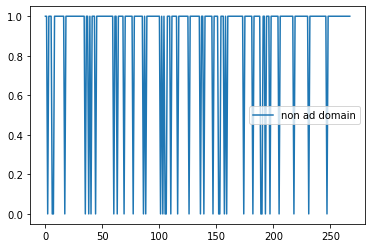

In [332]:
#pl.plot(dist_true,label='ad domain')
pl.plot(dist_false,label='non ad domain')
#pl.plot(dist_3rd,label='ad but unknown')
pl.legend()

In [333]:
domain_stat_test = pad_sequences(1*[bpe.encode('c.aaxads.com')],30,padding='post')
neg = pad_sequences(1*[bpe.encode('popville.com')],30,padding='post')
anch_pos = pad_sequences(1*[bpe.encode('adserv.popville.com')],30,padding='post')
anch_neg = pad_sequences(1*[bpe.encode('github.com')],30,padding='post')

#test_ref,test_query,test_anchors_1,test_anchors_2,_ = make_query_pairs(df,bpe,sample_count=1)
#test_ref_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_ref)),30,padding='post')
#test_query_enc = pad_sequences(list(map(lambda x: bpe.encode(x),neg)),30,padding='post')
#test_anchors_1_enc = pad_sequences(list(map(lambda x: bpe.encode(x),anch_pos)),30,padding='post')
#test_anchors_2_enc = pad_sequences(list(map(lambda x: bpe.encode(x),anch_neg)),30,padding='post')

init_preds = online_model.predict([domain_stat_test,neg,anch_pos,anch_neg])
print(init_preds)

[[9.9999917e-01 7.4799141e-06 9.9999833e-01 3.8719107e-04]]


In [112]:
def parse_domain(x):
    y = x.split('.')
    y = y[:-1]
    z = [i for i in y if i not in ['www']]
    return '.'.join(z)

parse_domain('imap.gmail.com')
df.domain.apply(lambda x: parse_domain(x))


0         mobile.pipe.aria.microsoft
1         mobile.pipe.aria.microsoft
2                  telemetry.dropbox
3                         login.live
4                         edge.skype
                     ...            
188894          xn--localbitcins-vcd
188895                   siambiznews
188896                lp.searchmulty
188897                         usibw
188898         leanproconsulting.com
Name: domain, Length: 188899, dtype: object